In [1]:
%load_ext autoreload
%autoreload 2

In [85]:
import torch
from matplotlib import pyplot as plt

from counterfactuals.datasets import MoonsDataset
from counterfactuals.cf_methods.ppcef import PPCEF
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import MultilayerPerceptron
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.metrics import evaluate_cf

### Import and plot dataset

In [3]:
dataset = MoonsDataset("../data/moons.csv")
train_dataloader = dataset.train_dataloader(batch_size=1024, shuffle=True)
test_dataloader = dataset.test_dataloader(batch_size=1024, shuffle=False)

X shape: torch.Size([819, 2])
y shape: torch.Size([819])


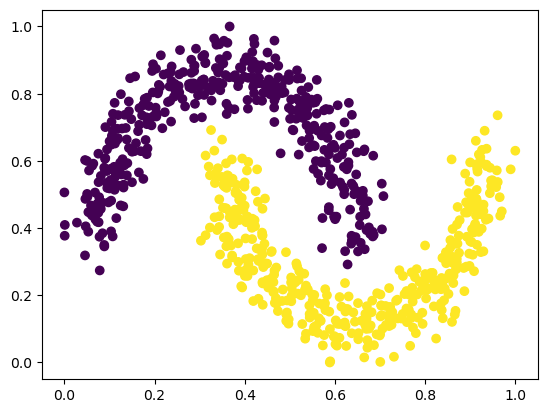

In [4]:
for X, y in train_dataloader:
    print(f"X shape: {X.shape}")  # torch.Size([1024, 2]) - x coordinates and y coordinates
    print(f"y shape: {y.shape}")  # torch.Size([1024])    - labels
    plt.scatter(X[:, 0], X[:, 1], c=y)

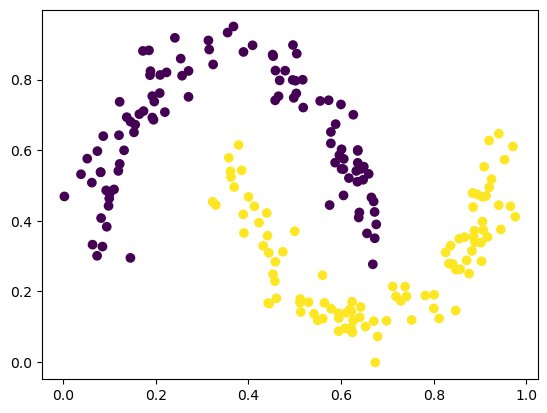

In [5]:
for X, y in test_dataloader:
    plt.scatter(X[:, 0], X[:, 1], c=y)

### Prepare (train) discrimative model for loaded data

In [33]:
train_dataloader = dataset.train_dataloader(batch_size=128, shuffle=True)
test_dataloader = dataset.test_dataloader(batch_size=128, shuffle=False)
disc_model = MultilayerPerceptron(
    input_size=2, hidden_layer_sizes=[256, 256], target_size=1, dropout=0.2
)
disc_model.fit(
    train_dataloader,
    test_dataloader,
    epochs=5000,
    patience=300,
    lr=1e-3,
)
disc_model.load("../models/MoonsDataset/disc_model_MultilayerPerceptron.pt")

Epoch 982, Train: 0.0403, test: 0.0343, patience: 300:  20%|█▉        | 983/5000 [00:43<02:56, 22.70it/s]


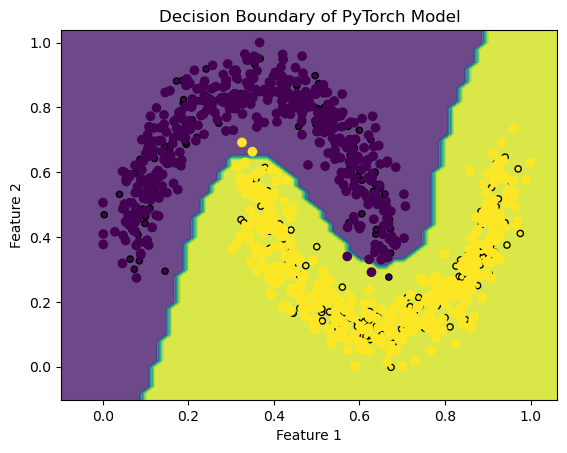

In [34]:
import numpy as np

# Create a mesh grid for plotting decision boundaries
h = 0.02
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Make predictions on the grid points
disc_model.eval()
with torch.no_grad():
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = disc_model.predict(grid_points)
    Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", s=20)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision Boundary of PyTorch Model")

for X, y in train_dataloader:
    plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [35]:
# Train the Masked Autoregressive Flow model
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1], hidden_features=8, context_features=1
)
gen_train_dataloader = dataset.train_dataloader(
    batch_size=1024, shuffle=True, noise_lvl=0.03
)
gen_model.fit(train_dataloader, test_dataloader, num_epochs=1000)

Epoch 232, Train: -1.5202, test: -1.5134, patience: 20:  23%|██▎       | 232/1000 [00:24<01:21,  9.43it/s]


In [37]:
# Train PPCEF with the generative and discriminative models

cf = PPCEF(
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=BinaryDiscLoss(),
    neptune_run=None,
)
cf_dataloader = dataset.test_dataloader(batch_size=1024, shuffle=False)
log_prob_threshold = torch.quantile(gen_model.predict_log_prob(cf_dataloader), 0.25)
deltas, X_orig, y_orig, y_target, logs = cf.explain_dataloader(
    cf_dataloader, alpha=100, log_prob_threshold=log_prob_threshold, epochs=4000
)

  0%|          | 0/4000 [00:00<?, ?it/s]

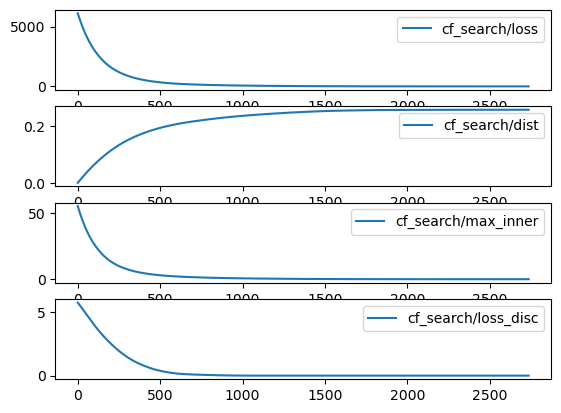

In [39]:
for i, (log_name, log_vals) in enumerate(logs.items()):
    plt.subplot(len(logs), 1, i + 1)
    plt.plot(log_vals, label=log_name)
    plt.legend()

In [40]:
X_cf = X_orig + deltas

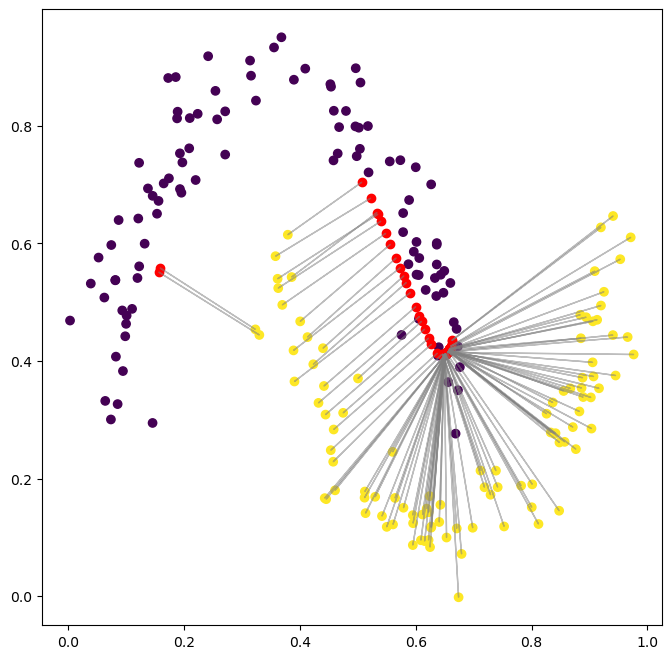

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))

i = y_orig.reshape(-1) == 1
ax.scatter(X_orig[:, 0], X_orig[:, 1], c=y_orig)
ax.scatter(X_orig[i, 0] + deltas[i, 0], X_orig[i, 1] + deltas[i, 1], c="r")
for before, after in zip(X_orig[i], X_cf[i]):
    ax.arrow(
        before[0],
        before[1],
        after[0] - before[0],
        after[1] - before[1],
        head_width=0.0,
        head_length=0.0,
        fc="gray",
        ec="gray",
        alpha=0.5,
        width=0.0001,
    )

In [86]:
evaluate_cf(
    disc_model=disc_model,
    gen_model=gen_model,
    X_cf=X_cf,
    model_returned=np.ones(X_cf.shape[0]),
    continuous_features=dataset.numerical_features,
    categorical_features=dataset.categorical_features,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_orig,
    y_test=y_orig,
    median_log_prob=log_prob_threshold,
    y_target=y_target,
)

{'coverage': 1.0,
 'validity': 1.0,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 0.25947778267834337,
 'proximity_continuous_manhattan': 0.33527586783577756,
 'proximity_continuous_euclidean': 0.25947778267834337,
 'proximity_continuous_mad': 1.7446448221439268,
 'proximity_l2_jaccard': 0.25947778267834337,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.9951219512195122,
 'log_density_cf': 1.3288089,
 'log_density_test': -54.015396,
 'lof_scores_cf': 1.0191901,
 'lof_scores_test': 1.0409402,
 'isolation_forest_scores_cf': 0.028115319674475826,
 'isolation_forest_scores_test': 0.0041604418163049064}